California housing prices dataset from 1990 California census (downloaded through kaggle.com). The goal is to make a model that learns from this data and predicts the median housing price in any district, given all the other features. A district is defined to be a block group, which has a population of 600-3000 people.

Description of datset features:

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housing_median_age: Median age of a house within a block; a lower number is a newer building

4. total_rooms: Total number of rooms within a block

5. total_bedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. median_income: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. median_house_value: Median house value for households within a block (measured in US Dollars)

10. ocean_proximity: Location of the house with respect to ocean/sea

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# Read the dataset
df = pd.read_csv('housing.csv')

In [3]:
# We see that there are 20640 rows or instances and 10 columns or features/attributes.
# All attributes are numerical except for "ocean_proximity". This is of type 'object', which is actually a text
# There are 207 missing values in 'total_bedrooms' column. We need to take care of these later.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# This is a categorical attribute and we need to take care of it in order to feed the data to a ML algorithm
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
# Summury of the numerical attributes
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# Check the first 5 entries
# Each row represents a district and each district has 10 attributes
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C032864CA0>,
      dtype=object)

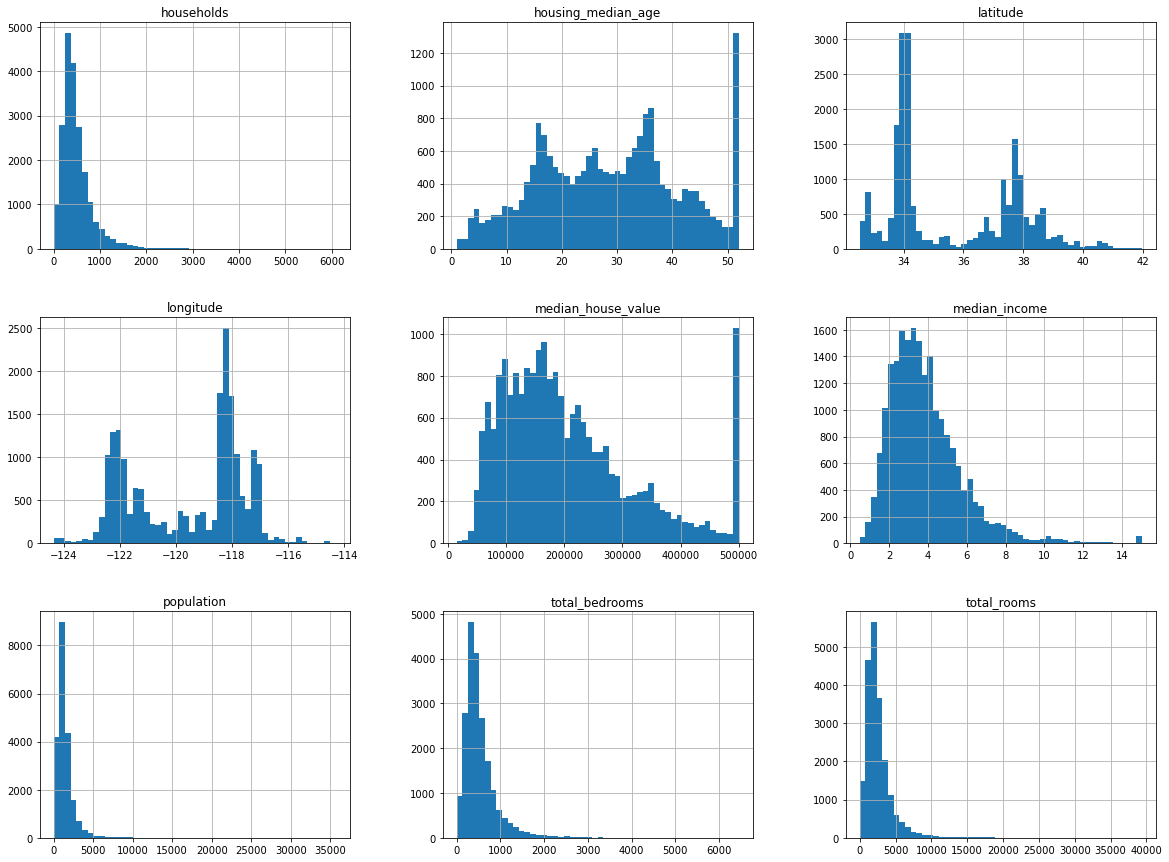

In [7]:
# Histograms of each numerical attribute using Matplotlib
df.hist(bins=50,figsize=(20,15))

Since our dataset is not very large and the statistical population can be broken down into distinctive subgroups, we will use stratified sampling. 

So we divide our population into multiple non-overlaping, homogeneous groups (called strata) and randomly choose members from those strata. This method reduces cost and improves efficiency.  The members of each stratum are distinct, so they have equal opportunity to be selected.

First we will use "median_income" to divide our districts. As we can see from the median income histogram above, most districts fall between 20000-50000 USD, but there also a few above 60000 USD. So we can divide the median income into 5 income categories 1,2,3,4 and 5 where every district which has median income above 60000 USD will belong to the 5th category.

In [8]:
# Compress the range of values and round up with a ceiling in order to have discrete categories
df['income_category'] = np.ceil(df['median_income']/1.5)

In [9]:
df['income_category'].value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_category, dtype: int64

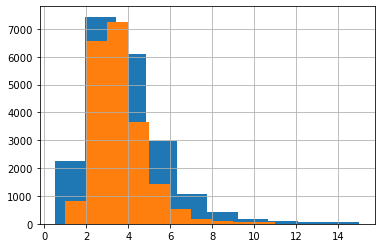

In [10]:
df['median_income'].hist()
df['income_category'].hist()

In [11]:
# Change the categories above 5 to belong to category 5 using .where which replaces values if the condition is False
df['income_category'].where(df['income_category'] < 5, 5.0, inplace=True)

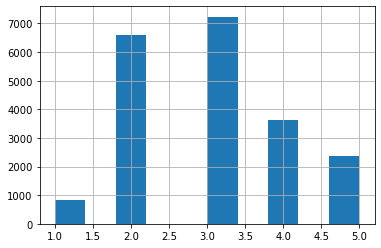

In [12]:
df['income_category'].hist()

In [13]:
# Split the data
from sklearn.model_selection import StratifiedShuffleSplit
strat_split = StratifiedShuffleSplit(1,test_size=0.2,random_state=42)

for train_index, test_index in strat_split.split(df,df['income_category']):
    stratified_train = df.loc[train_index]
    stratified_test = df.loc[test_index]

Let us check the income_category proportions before and after the splitting:

In [14]:
# Proportions of the full dataset
prop_df = df['income_category'].value_counts()/len(df['income_category'])
# Proportions of the stratified_test set
prop_strat_test = stratified_test['income_category'].value_counts()/len(stratified_test['income_category'])

print(prop_df)
print('\n')
print(prop_strat_test)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category, dtype: float64


3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_category, dtype: float64


We observe that the error is small so the splitting worked really well and the test set has income_category proportions almost identical to those in the full dataset.

In [15]:
# Check the error of splitting
stratified_error = (prop_df - prop_strat_test)/prop_df*100
stratified_error

3.0    0.013820
2.0    0.015195
4.0   -0.027480
5.0   -0.127011
1.0    0.243309
Name: income_category, dtype: float64

We can do the same procedure using random sampling with train_test_split to get another test set and check again the error of the new splitting.

In [16]:
from sklearn.model_selection import train_test_split
random_train, random_test = train_test_split(df,test_size=0.2,random_state=42)

Let us check the income_category proportions before and after the splitting:

In [17]:
# Proportions of the random_test set
prop_rand_test = random_test['income_category'].value_counts()/len(random_test['income_category'])

print(prop_df)
print('\n')
print(prop_rand_test)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_category, dtype: float64


3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_category, dtype: float64


So we can see that the error this time is much bigger and therefore the stratified sampling is a better choice.

In [18]:
# Check the error of splitting
stratified_error = (prop_df - prop_rand_test)/prop_df*100
stratified_error

3.0   -2.266446
2.0   -1.732260
4.0    5.056334
5.0    4.318374
1.0   -0.973236
Name: income_category, dtype: float64

In [19]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


Now we have splitted the data using stratified sampling, we no longer need the income_category column so we drop it from our dataset as well as from stratified_train and stratified_test sets.

In [20]:
df.drop('income_category',axis=1,inplace=True)
stratified_train.drop('income_category',axis=1,inplace=True)
stratified_test.drop('income_category',axis=1,inplace=True)

To proceed with the exploration of the data, we need to work with the train set, so we make a copy of it to work with.

In [21]:
df_train = stratified_train.copy() # Make a copy of the training set
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


Let us visualise our data using a scatterplot, based on longitute and latitude to see the distribution of the districts. Obviously more expensive districts are closer to the ocean and this means that the ocean_proximity attribute will be useful, although there are some coastal districts in northern California where the housing prices are not too high compared to central and southern California.

In [22]:
# Check the minimum and maximum values of both longitude and latitude 
# so we can download a map of California from  https://www.openstreetmap.org/
long_max = df_train['longitude'].max()
long_min = df_train['longitude'].min()
lat_max = df_train['latitude'].max()
lat_min = df_train['latitude'].min()
print(long_min,long_max,lat_min,lat_max)
BBox = ((long_min,long_max,lat_min,lat_max)) # Bounding Box that includes all spatial points of our dataset

-124.35 -114.31 32.54 41.95


In [23]:
# Load the map
path = 'C:/Users/Sotiris/Desktop/California_map.png'
img = plt.imread(path)

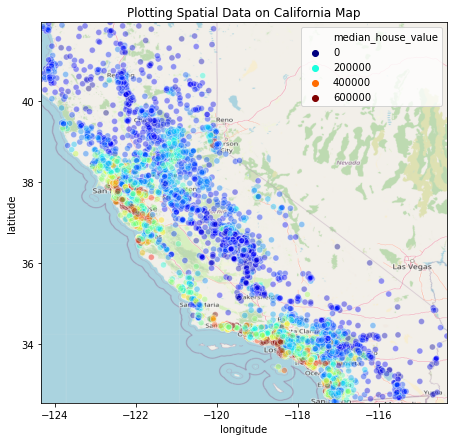

In [24]:
fig, ax = plt.subplots(figsize = (10,7))
sns.scatterplot(x='longitude',y='latitude',data=df_train,alpha=0.4,palette='jet',hue='median_house_value')
ax.set_title('Plotting Spatial Data on California Map')
ax.set_xlim(BBox[0],BBox[1]) # Set the x-axis to be between long_min and long_max
ax.set_ylim(BBox[2],BBox[3]) # Set the y-axis to be between lat_min and lat_max
ax.imshow(img, extent = BBox, aspect= 'equal')

We continue by exploring the correlation between the attributes.

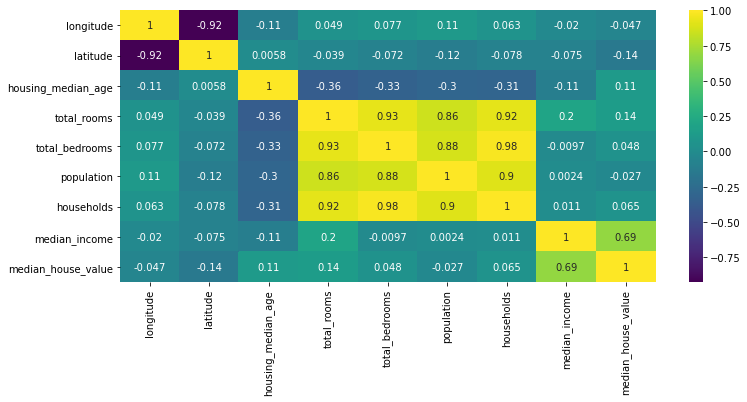

In [25]:
# Check the correlations of the attributes
plt.figure(figsize=(12,5))
sns.heatmap(df_train.corr(),annot=True,cmap='viridis')

In [26]:
# Which attributes correlate with our target median_house_value?
df_train.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

We see that there are a few interesting attributes so we can explore them further by plotting some scatter plots.

<Figure size 1440x576 with 0 Axes>

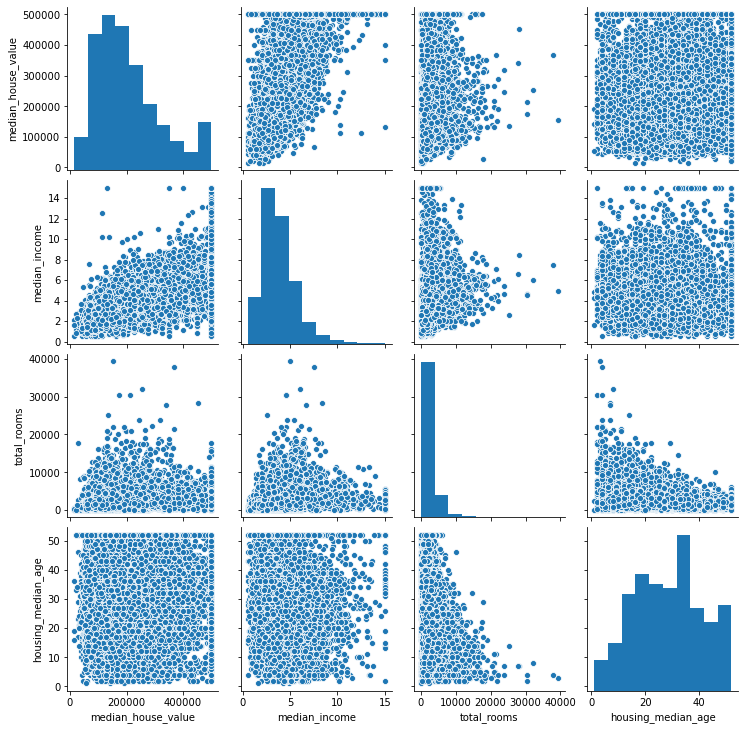

In [27]:
plt.figure(figsize=(20,8))
sns.pairplot(df_train[['median_house_value','median_income','total_rooms','housing_median_age']])

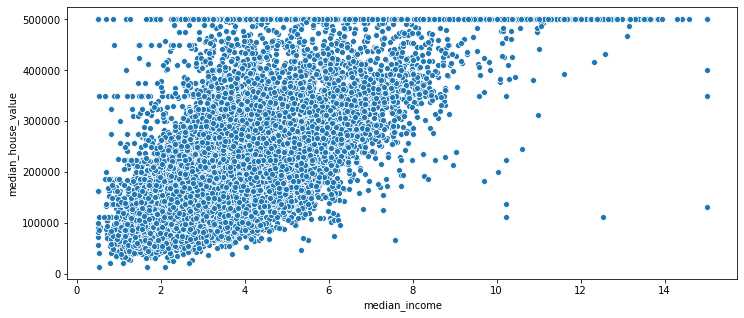

In [28]:
plt.figure(figsize=(12,5))
sns.scatterplot(df_train['median_income'],df_train['median_house_value'])

By the above scatterplot, we observe that there is a price cap at 500000 USD as that line indicates. Actually, there are more horizontal lines, for example at 450000 USD, 350000 USD and maybe more below these. So we try to remove these in the next steps.

In [29]:
# All the districts with median house value over 500000, actually they are capped at 500001 USD
df_over_500000 = df_train[df_train['median_house_value'] > 500000]
df_over_500000['median_house_value'].value_counts()

500001.0    786
Name: median_house_value, dtype: int64

In [30]:
df_train.drop(df_over_500000.index,inplace=True)

In [31]:
# Drop the districts with median income less than 3 and median house value 450000 & 350000 USD
df_450000 = df_train[(df_train['median_income'] < 3) & (df_train['median_house_value'] == 450000)]
df_350000 = df_train[(df_train['median_income'] < 3) & (df_train['median_house_value'] == 350000)]
df_train.drop(df_350000.index,inplace=True)
df_train.drop(df_450000.index,inplace=True)

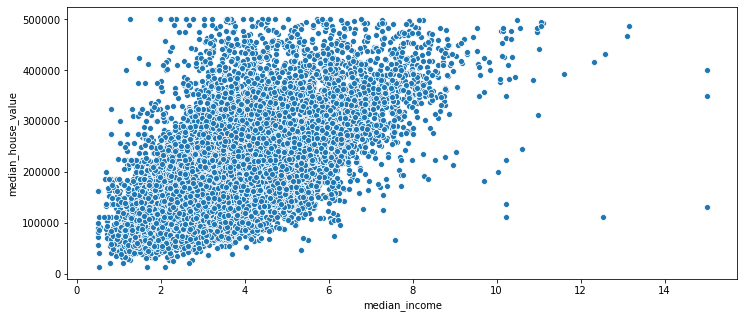

In [32]:
plt.figure(figsize=(12,5))
sns.scatterplot(df_train['median_income'],df_train['median_house_value'])

There are a few more things we need to do before we feed the data to a ML algorithm. We know the total number of rooms, bedrooms, households and population in each district. So we can add some extra attributes, such as population per household, rooms per household or any other combination (that makes sense) and check their correlation with our target attribute.

In [33]:
df_train['population_per_household'] = df_train['population']/df_train['households']
df_train['rooms_per_household'] = df_train['total_rooms']/df_train['households']
df_train['bedrooms_per_room'] = df_train['total_bedrooms']/df_train['total_rooms']

In [34]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,population_per_household,rooms_per_household,bedrooms_per_room
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.094395,4.625369,0.223852
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,2.707965,6.008850,0.159057
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.025974,4.225108,0.241291
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,4.135977,5.232295,0.200866
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.047847,4.505810,0.231341


In [35]:
# We see that the attribute bedrooms_per_room is more correlated with the target than the total_rooms or total_bedrooms
df_train.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.650473
total_rooms                 0.146672
rooms_per_household         0.110439
households                  0.095704
total_bedrooms              0.074416
housing_median_age          0.072821
population                  0.012008
population_per_household   -0.019463
longitude                  -0.043445
latitude                   -0.150609
bedrooms_per_room          -0.238235
Name: median_house_value, dtype: float64

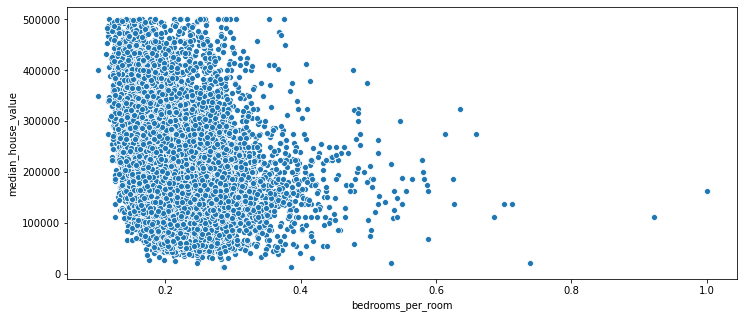

In [36]:
# Check the correlation with the bedrooms_per_room attribute
plt.figure(figsize=(12,5))
sns.scatterplot(y='median_house_value',x='bedrooms_per_room',data=df_train)

Let us now treat the ocean proximity feature. A good way to deal with categorical columns is to create dummy variables.

In [37]:
# Create a dummy variable and drop the first column
ocean = pd.get_dummies(df_train['ocean_proximity'],drop_first=True)

In [38]:
# Check the dummy variable. If every feature is 0 then we know that this particular district belongs to <1H ocean
ocean.head()

,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,0,0,0,0
18632,0,0,0,0
14650,0,0,0,1
3230,1,0,0,0
3555,0,0,0,0


In [39]:
# Concatenate the new columns to our training set
df_train = pd.concat([df_train,ocean],axis=1)
# Check our new dataframe
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,population_per_household,rooms_per_household,bedrooms_per_room,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.094395,4.625369,0.223852,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,2.707965,6.008850,0.159057,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.025974,4.225108,0.241291,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,4.135977,5.232295,0.200866,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.047847,4.505810,0.231341,0,0,0,0


In [40]:
#We can now drop the ocean_proximity attribute since we no longer need it
df_train.drop('ocean_proximity',axis=1,inplace=True)
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,population_per_household,rooms_per_household,bedrooms_per_room,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,2.094395,4.625369,0.223852,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,2.707965,6.008850,0.159057,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,2.025974,4.225108,0.241291,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,4.135977,5.232295,0.200866,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,3.047847,4.505810,0.231341,0,0,0,0


In [41]:
# It seems that our target correlates with our new features constructed by the ocean_proximity column
df_train.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.650473
NEAR BAY                    0.152831
total_rooms                 0.146672
NEAR OCEAN                  0.133532
rooms_per_household         0.110439
households                  0.095704
total_bedrooms              0.074416
housing_median_age          0.072821
ISLAND                      0.018478
population                  0.012008
population_per_household   -0.019463
longitude                  -0.043445
latitude                   -0.150609
bedrooms_per_room          -0.238235
INLAND                     -0.496951
Name: median_house_value, dtype: float64

Now it is time to treat the missing values. There are a few ways to do that:
1. We can drop districts which have a missing value
2. We can drop the whole feature, e.g total_bedrooms and bedrooms_per_room (which was constructed by the first)
3. Fill in the missing values with some value. This can be zero, the mean of that column, the median etc.

In [42]:
df_train.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              153
population                    0
households                    0
median_income                 0
median_house_value            0
population_per_household      0
rooms_per_household           0
bedrooms_per_room           153
INLAND                        0
ISLAND                        0
NEAR BAY                      0
NEAR OCEAN                    0
dtype: int64

In [43]:
total_bedrooms_median = df_train['total_bedrooms'].median()

In [44]:
# Fill in the missing values using the above medians
df_train['total_bedrooms'].fillna(total_bedrooms_median,inplace=True)

# Reassign the bed_rooms_per_room attribute now that we have no missing values
df_train['bedrooms_per_room'] = df_train['total_bedrooms']/df_train['total_rooms']

In [45]:
# Fill in the missing values of the test set as well
df_test = stratified_test.copy() # Make a copy of the stratified test set
df_test['total_bedrooms'].fillna(total_bedrooms_median,inplace=True)

In [46]:
# Drop the districts with median house value over 500000 from the test set
over_500000 = df_test[df_test['median_house_value'] > 500000]
df_test.drop(over_500000.index,inplace=True)

The numerical data of our dataframe have very different scales so it is a good idea to apply feature scaling on them. There are two techniques to consider here, min-max scaling (also called normalization) and standardization. Here we will use standardization since it is much less affected by outliers.

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()

In [49]:
# We do not have to scale the values of our target feature, i.e. median_house_value so we drop it first
housing = df_train.drop('median_house_value',axis=1)
housing_target = df_train['median_house_value']

In [50]:
scaler.fit(housing)

StandardScaler()

Finally we can train and evaluate a Machine Learning model! We evaluate the model using the Root Mean Squared Error and we use cross validation for better evaluation.

The K-fold cross-validation splits randomly the training set into K distinct subsets, which we call folds. Then it trains and evaluates the model K times, picking a different fold each time and training on the remaining K-1 folds. The result we get is an array containing the K evaluation scores.

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error          
from sklearn.model_selection import cross_val_score   

# Create the model
linear_model = LinearRegression()                       

In [52]:
# Pass in the model, the training and target data, the scoring function and the number of folds
scores_linear = cross_val_score(linear_model,housing,housing_target,scoring="neg_mean_squared_error",cv=10)

# Compute the root mean squared error using a minus since the above scores are negative
root_mean_error_linear = np.sqrt(-scores_linear)

# Print the scores, their mean and standard deviation
print('Scores: ',root_mean_error_linear,'\n\nMean: ',root_mean_error_linear.mean(),'\nStandard Deviation: ',root_mean_error_linear.std())

Scores:  [57892.34565719 58779.9200524  62983.35730856 63995.25549416
 60676.24849672 60343.25447247 57545.09459479 57835.71122492
 62210.46854377 59221.21965008] 

Mean:  60148.28754950713 
Standard Deviation:  2176.0493872418806


We observe that most of the districts have median house value between 120000 and 250000 USD so the above error of is not what we expect to see.

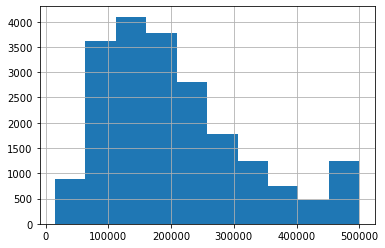

In [53]:
df['median_house_value'].hist()

The above model is unable to capture the relationship between the input and output variables accurately, so it cannot make good predictions and we have underfitting. To fix this problem we can use a more powerful model with more parameters, feed better features to the learning algorithm (feature engineering) or reduce the constraints on the model. Let us try the Random Forest model.

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Creat a model
forest_regressor = RandomForestRegressor()

In [55]:
# Pass the model, training and target data, scoring function and the number of folds
scores_forest = cross_val_score(forest_regressor,housing,housing_target,scoring="neg_mean_squared_error",cv=10)

# Compute the root mean squared error using a minus since the above scores are negative
root_mean_error_forest = np.sqrt(-scores_forest)

# Print the scores, their mean and standard deviation
print('Scores: ',root_mean_error_forest,'\n\nMean: ',root_mean_error_forest.mean(),'\nStandard Deviation: ',root_mean_error_forest.std())

Scores:  [44115.82284    42009.28953658 46056.27808631 45584.37657783
 45155.10062714 45074.47834357 43909.92468722 43324.90860328
 46690.10099622 44596.97016377] 

Mean:  44651.72504619253 
Standard Deviation:  1304.3410712511043


It seems that the random forest model performs better than the linear regression. We can make some small adjustments in order to achieve a maybe better result. To do that we can manually change the hyperparameters until we find a good combination, or we can use GridSearcCV to search them for us.

In [56]:
from sklearn.model_selection import GridSearchCV

# The most important hyperparameters of Random Forest Regressor are n_estimators and max_features
param_grid = {'n_estimators':[110,120,130],'max_features':[3,6,9]} # We try these combinations

# Create a base model
reg = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(reg,param_grid,scoring="neg_mean_squared_error",cv=10)

# Fit our search to the data
grid_search.fit(housing,housing_target)

# Get the best combination of parameters 
grid_search.best_params_

{'max_features': 6, 'n_estimators': 120}

In [57]:
# Create a model with our best parameters
reg = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],max_features=grid_search.best_params_['max_features'])

# Pass the model, training and target data, scoring function and the number of folds
scores_forest = cross_val_score(reg,housing,housing_target,scoring="neg_mean_squared_error",cv=10)

# Compute the root mean squared error using a minus since the above scores are negative
root_mean_error_forest = np.sqrt(-scores_forest)

# Print the scores, their mean and standard deviation
print('Scores: ',root_mean_error_forest,'\n\nMean: ',root_mean_error_forest.mean(),'\nStandard Deviation: ',root_mean_error_forest.std())

Scores:  [43419.7371315  41456.65950261 45476.86786838 44818.37559837
 44350.83786343 44788.0702275  43568.90561743 42651.38209941
 45698.09491441 44155.32090434] 

Mean:  44038.42517273575 
Standard Deviation:  1236.8429036831585


We see that this model performs a bit better than the previous we got, so we can proceed to the evaluation on the test set.

In [58]:
df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
20552,-121.80,38.68,11.0,3851.0,892.0,1847.0,747.0,3.4331,120600.0,INLAND


In [59]:
# Get the predictors and the taget of the test set
X_test = df_test.drop('median_house_value',axis=1)
y_test = df_test['median_house_value'].copy()

Now we need to prepare the X_test dataframe for the predictions. This means, we have to do again what we did to our train set.

In [60]:
# Add the combined features
X_test['population_per_household'] = X_test['population']/X_test['households']
X_test['rooms_per_household'] = X_test['total_rooms']/X_test['households']
X_test['bedrooms_per_room'] = X_test['total_bedrooms']/X_test['total_rooms']

In [61]:
# Create a dummy variable and drop the first column
ocean = pd.get_dummies(X_test['ocean_proximity'],drop_first=True)

In [62]:
# Concatenate the new columns to our test set
X_test = pd.concat([X_test,ocean],axis=1)

#Drop the ocean_proximity column
X_test.drop('ocean_proximity',axis=1,inplace=True)

# Check our new dataframe
X_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,2.563748,6.388633,0.157490,0,0,0,0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,2.408676,4.973744,0.212532,0,0,0,0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,3.161491,5.546584,0.171333,1,0,0,0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,3.533113,5.877483,0.176901,1,0,0,0
20552,-121.80,38.68,11.0,3851.0,892.0,1847.0,747.0,3.4331,2.472557,5.155288,0.231628,1,0,0,0


In [63]:
# Rescale the features
scaler.fit(X_test)

StandardScaler()

In [64]:
# Create the model with the best parameters
model = grid_search.best_estimator_

In [65]:
# Get the predictions
predictions = model.predict(X_test)

In [66]:
# Compute the mean squared error and its root
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Print the final Root Mean Squared Error
print(rmse)

43470.1674447676


In [67]:
#
from sklearn.metrics import mean_absolute_error

In [68]:
# Check the mean absolute error
mean_absolute_error(y_test,predictions)

29419.589579640415

In [69]:
# Check the mean of the target column
df['median_house_value'].mean()

206855.81690891474

By comparing the error metrics to the above mean, we can get an intuition of the overall performance of our model.